# Once upon a time in Algotel

This is the companion notebook of the paper *Il était une fois Algotel* (Once upon a time in Algotel).

## Setup

We assume you have executed the notebook ``data_preparation.ipynb`` to produce a file ``algotels_xgismo.pkl.gz``. If it not the case, please start with that notebook!

### Loading xgismo+spacy

If needed, adjust ``data_folder`` to point to the location of your ``algotels_xgismo.pkl.gz`` file.

In [1]:
from pathlib import Path
data_folder = Path("../../../../../datasets")
data_folder.exists()

True

Load the xgismo.

In [2]:
from gismo.gismo import XGismo
xgismo = XGismo(filename="algotels_xgismo", path=data_folder)

That xgismo relies on spacy and its save does not embed the spacy NLP engine, so we need to load it separately.

In [3]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
keep = {'ADJ', 'NOUN', 'NUM', 'PROPN', 'SYM', 'VERB'}

Quick test, with the request *coloring*

In [4]:
xgismo.rank("coloring")

True

Associated vocabulary.

In [5]:
", ".join(xgismo.get_features_by_rank())

'color, coloring, edge, image, edge color, planar, number, vertex, complexity, color image, color graph, path, tree, cycle, maximum, set, planar graph, free, preface, edge color graph, chromatic, color problem, conjecture'

Associated authors

In [6]:
", ".join(xgismo.get_documents_by_rank())

'George_Paschos, Yannis_Manoussakis, Lukasz_Kowalik, Louis_Esperet, Hocine_Cherifi, Oleg_V._Borodin, André_Raspaud, Frédéric_Maffray, Magnús_M._Halldórsson, Jiaojiao_Wu, Guillaume_Fertin, Benjamin_Lévêque, Bernard_Ries, Victor_A._Campos, Alain_Trémeau, Manoel_B._Campêlo, Reinhardt_Euler, Pavol_Hell, Nicolas_Gastineau, Alexandre_Nolin, Carlos_A._J._Martinhon, Hong_Phong_Pham, Ana_Silva_0001, François_Jaeger, Mohammed_El_Hassouni, Constantin_Vertan, Éric_Sopena, Alexandre_Pinlou, Janusz_Dybizbanski, Shinnosuke_Seki, Mounir_Omari, Christine_Fernandez-Maloigne, Abdelkaher_Ait_Abdelouahad'

Number of keywords:

In [7]:
xgismo.embedding.m

34384

Number of authors:

In [8]:
xgismo.embedding.n

93841

### loading and formating Algotel program committes

We load the provided file.

In [9]:
import json, gzip
with gzip.open('algotels_1999_2022.json.gz', 'rt', encoding='utf8') as f:
    algotels = json.load(f)

We re-arrange slighly the content of ``algotels`` to make it easier to process afterwards. In details, we flatten the content into a corpus (list of dict), each dict having a display name (`name`) and a usable content (`dblp`).

In [10]:
algotels_lmks = [{'name': k, 'dblp': " ".join(v)} for k, v in algotels['by_year'].items()]

Last step: train the corpus. Each entry will be associated by the xgismo engine to a vector of authors and a vector of vocabulary. In Gismo terms, the association of a corpus of items to a double-vector representation is called *landmarks*.

Luckily, the creation of *landmarks* is fully implemented by gismo.

In [11]:
from gismo.landmarks import Landmarks
committees_landmarks = Landmarks(source=algotels_lmks, to_text=lambda x: x['dblp'],
                           rank = lambda g, q: g.rank(q, y=False))
committees_landmarks.fit(xgismo)

A few tests: which committees were more adapted to satellites? (``max_k`` and ``target_k`` are hyper-parameters to adjust the number of results returned).

In [12]:
xgismo.rank("Satellites communications")
committees_landmarks.post_item = lambda l, i: l[i]['name']
committees_landmarks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2003', '2002', '2001']

What about self-stabilization?

In [13]:
xgismo.rank("Self stabilization")
committees_landmarks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2017']

Blockchains?

In [14]:
xgismo.rank("Blockchains")
committees_landmarks.get_landmarks_by_rank(xgismo, target_k=1.1, max_k=10)

['2020', '2021']

OK, things seem to be working. We can start the actual study.

## Relationships across the years

Here, we propose to analyze how similar the committees are with each others.

We will compare how similar the different editions are with each other using *cosine similarity* and display the results in a 2-dimensional *heatmap*. The following cell defines a generic function for this purpose.

In [15]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

def pre_map(lmks, slc=None, get_name=None, balance=.5):
    """
    Extract vectorial representation and ticks from a Landmark object.
    
    Parameters
    ----------
    lmks: Landmarks
        Landmarks to process.
    slc: slice, optional
        Subset of ticks to return.
    get_name: func, optional
        Callback to extract tick label from landmark.
    balance: float, optional
        Author / vocabulary trade-off
        
    Returns
    -------
    vect: sparse matrix
        Vectorial representation
    ticks: list
        ticks indexes
    tick_labels: list of str
        Labels
    """
    if slc is None:
        slc = slice(len(lmks))
    if get_name is None:
        get_name = lambda l: l
    vect = lmks.get_base(balance=balance)
    ticks = np.arange(len(lmks))[slc]
    tick_labels = [get_name(a) for a in lmks[slc]]
    return vect, ticks, tick_labels

def draw_heatmap(x_lmks, x_slice=None, x_name=None,
                 y_lmks=None, y_slice=None, y_name=None,
                 tikz=None, balance=.5, y_key=None,
                 vmin=None, vmax=None):
    """
    Display a heatmap that to analyze one or two landmarks.
    
    Parameters
    ----------
    x_lmks: Landmarks
        Landmarks for axis x.
    x_slice: slice, optional
        Subset of ticks to return for axis x.
    x_name: func, optional
        Callback to extract tick label from x_lmks.
    y_lmks: Landmarks, optional
        Landmarks for axis y. If None, x_lmks will be used as y_lmks as well (self-analysis).
    y_slice: slice, optional
        Subset of ticks to return for axis y.
    y_name: func, optional
        Callback to extract tick label from y_lmks.
    tikz: str, optional
        If set, will save the plot in pgfplots format with the assigned name (requires tikzplotlib package installed).
    balance: float, optional
        Author / vocabulary trade-off.
    y_key: func, optional
        if set, will be applied to the similarity matrix to produce `len(y_lmks)` values. 
        These values will be used to re-order the Y entries.
    vmin: float, optional
        Lower bound for the heatmap
    vmax: float, optional
        Upper bound for the heatmap
    """
    x_vect, x_ticks, x_labels = pre_map(x_lmks, x_slice, x_name, balance)
    if y_lmks is None:
        y_vect, y_ticks, y_labels = x_vect, x_ticks, x_labels
    else:
        y_vect, y_ticks, y_labels = pre_map(y_lmks, y_slice, y_name, balance)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    # LICO! y first for lines
    sims = cosine_similarity(y_vect, x_vect)
    if y_key is not None:
        values = y_key(sims)
        y_sort = np.argsort(values)
        sims = sims[y_sort, :]
        y_labels = [y_labels[i] for i in y_sort]
    cax = ax.matshow(sims, cmap=plt.cm.jet, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cax)
    cbar.set_label('Similarity', rotation=270, labelpad=10)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # to save as .tex. tikzplotlib library required
    # to rotate colormap label, use the following in the tex source
    # colorbar style={ylabel={Similarity}, ylabel style={rotate=180}},
    if tikz is not None:
        import tikzplotlib
        tikzplotlib.save(tikz)

    plt.show()    

The following extracts vectorial representations of the committees from 1999 to 2021.

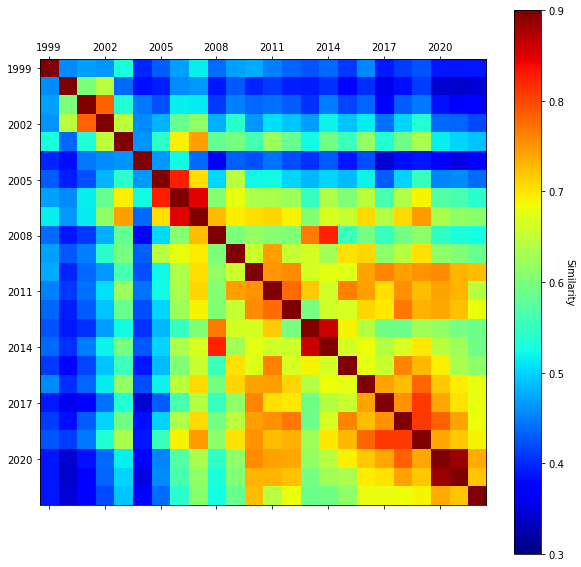

In [16]:
draw_heatmap(committees_landmarks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], vmax=.9, vmin=.3) #, tikz="years.tex")

Interpretation:
- years with bright colors are similar between them
- There is a small cluster of early Algotels (2000-2003 very roughly)
- Main cluster that continues today started in 2003 but roughly stabilized in 2009.
- One *strange* year: 2004.
- A few twin-editions (e.g. 2001-2002, 2004-2005-2006. 2013-2014, 2020-2021), corresponding to higher committee overlaps.
- Core of the main cluster: 2010-2012 + 2016-2021.

Side investigation on year 2004.

In [17]:
xgismo.rank(" ".join(algotels['by_year']['2004']), y=False)

True

In [18]:
", ".join(algotels['by_year']['2004'])

'Gerard_Authié, François_Baccelli, Evripidis_Bampis, Lila_Boukhatem, Fabrice_Chauvet, Pierre_Eisenmann, Pierre_Fraigniaud, Isabelle_Guérin_Lassous, Frédéric_Havet, Anne-Marie_Kermarrec, Jean-Claude_König, Martine_Labbé, Olivier_Marc, Adam_Ouorou, André_Raspaud, Catherine_Rosenberg, Kavé_Salamatian, Nicolas_Schabanel, Ioan_Todinca, Laurent_Truffet, Guillaume_Vivier'

In [19]:
", ".join(xgismo.get_features_by_rank())

'steiner problem graphs, gprs, steiner problem, problem graphs, heuristic, edge network, steiner, erlang, imitation, cupcarbon, parallel, edge, de bruijn kautz, bruijn kautz, kautz, pool, retrial, bruijn, de bruijn, car, like, aadl, emulator, center, multiplicity, law, self, lab, shortest paths, impact, optimization, character'

## Lincs between topics and committes

We can zoom on a set of topics and observe how well it was represented in the program committees. We decided to zoom on 3 sets:
- The official 2022 Algotel topics
- The official 1999 Algotel topics
- The official 2010 Algotel topics

In [20]:
topics_1999 = ['Mobile and satellite telecommunications',
              'Dimensioning',
              'Routing',
              'Optical technologies',
              'Multi-point communications']

In [21]:
topics_2010 = ['Energy efficient networks', 
              'Distributed algorithms for networks',
              'New generation cellular networks',
              'Algorithms for interaction networks',
              'Resource allocation',
              'Configuration, routing, and QoS in large scale networks',
              'Self-organized radio networks',
              'Fault and attack tolerance']

In [22]:
topics_2022 =['Cloud Computing, Data Centers, Virtualization',
              'Blockchains',
              'Configuration and Routing in Large Scale Networks',
              'Management and mining of massive data',
              'Wireless, ad hoc, cellular, 5G, optical, satellite networks',
              'VANET, IoT, robot, wearable, sensor networks',
              'Complex, social, interaction, opportunistic networks', 
              'P2P, edge networks', 
              'CDN, CCN, NDN networks',
              'Network programming: SDN, NFV', 
              'Security and Privacy', 
              'Fault tolerance',
              'Green networking, Energy efficient systems',
              'Concurrency, synchronization and transactional memory',
              'Parallel and distributed algorithms for networks',
              'Algorithms for distributed data processing',
              'Self-stabilization, self-organization and autonomous systems',
              'Modeling and performance evaluation',
              'Graphs and dynamic networks',
              'Graph and network measurement', #'Graph and network metrology',
              'Scheduling, operational research and optimization',
              'Machine learning, distributed learning, collaborative game theory',
              'Planning, network sizing, resource allocation',
              'Stochastic geometry']

In [23]:
topics_1999_lmks = Landmarks(source=topics_1999)
topics_1999_lmks.fit(xgismo)

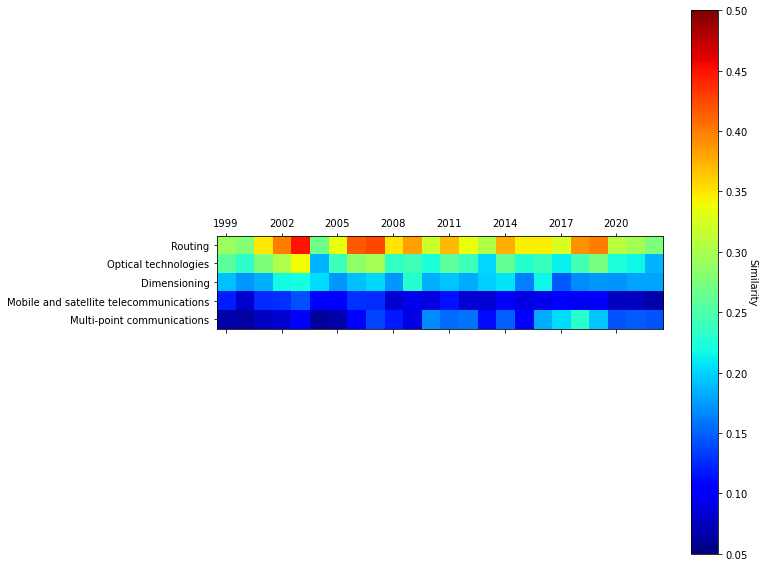

In [24]:
draw_heatmap(committees_landmarks, x_slice=slice(0, 23, 3), x_name=lambda a: a['name'], y_lmks=topics_1999_lmks,
             vmin=.05, vmax=.5, y_key=lambda s: -s[:, 0], tikz="topics_1999.tex")

In [25]:
topics_2010_lmks = Landmarks(source=topics_2010)
topics_2010_lmks.fit(xgismo)

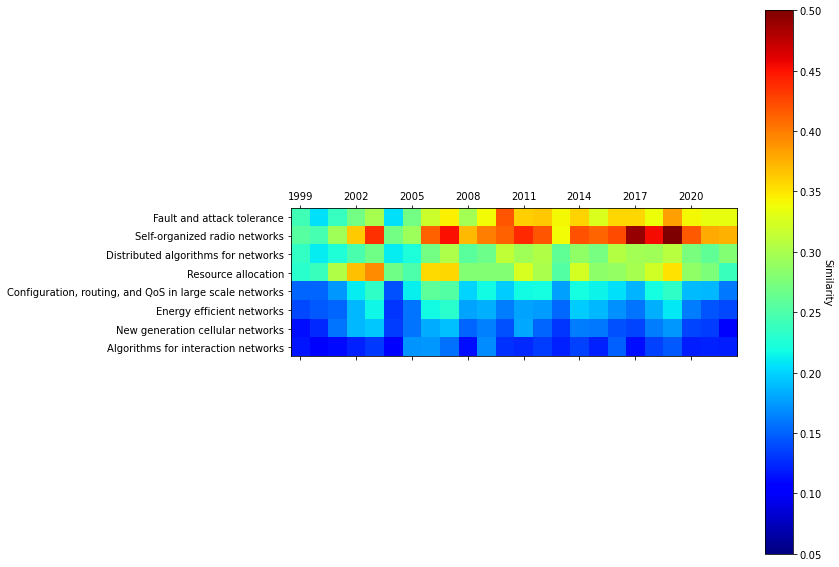

In [26]:
draw_heatmap(committees_landmarks, x_slice=slice(0, 22, 3), x_name=lambda a: a['name'], y_lmks=topics_2010_lmks,
             vmin=.05, vmax=.5, y_key=lambda s: -s[:, 11], tikz="topics_2010.tex")

In [27]:
topics_2022_lmks = Landmarks(source=topics_2022)
topics_2022_lmks.fit(xgismo)

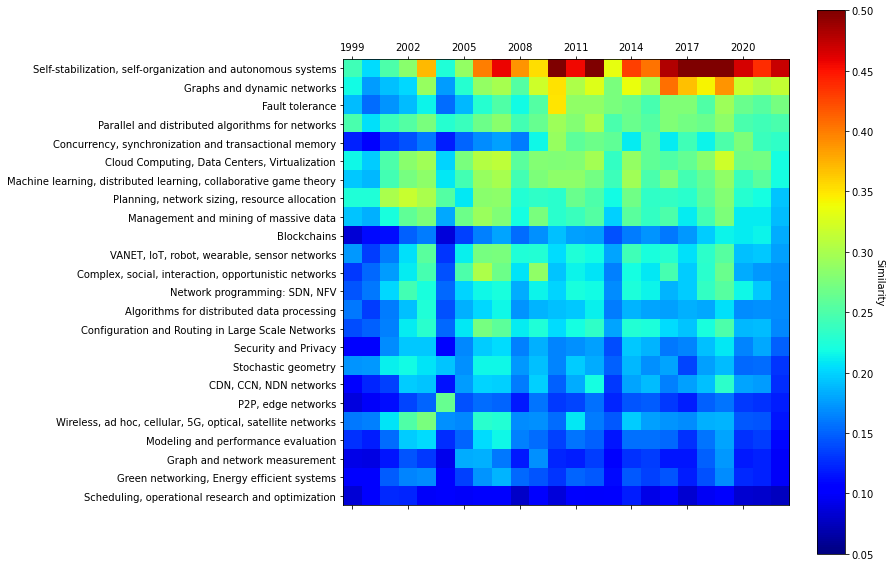

In [28]:
draw_heatmap(committees_landmarks, x_slice=slice(0, 23, 3), x_name=lambda a: a['name'], y_lmks=topics_2022_lmks,
             vmin=.05, vmax=.5, y_key=lambda s: -s[:, -1], tikz="topics_2022.tex")

## instant committee recommendation

To demonstrate a small but useful feature of Gismo, we propose a function to help deciding members of a program committee with respect to a new field.

In [29]:
algotel_pc_members = {a for y in committees_landmarks for a in y['dblp'].split()}

def spacify(name):
    return name.replace("_", " ")

def new_pc_proposal(query, k=10, overlap=None):
    """
    Propose a selection of researchers to cover a topic.
    
    Parameters
    ----------
    query: str
        The topic that we want to cover.
    k: int, optional
        Number of researchers that will be proposed (default to 10).
    overlap: float, optional
        If set, about overlap % of returned researchers will be members of previous committees.
        If not, the k more relevant researchers will be returned regardless of their previous memberships.
        
    Returns
    -------
    dict
        Dictionary with two entries, one for former committee members, one for new members. 
        For each member, the name and rank (a.k.a relevance to the query, rank is NOT an indication of value) is returned.
    """
    success = xgismo.rank(query)
    if not success:
        print("Request not found")
        return False
    
    print(f"Looking for researchers involved in: {', '.join(xgismo.get_features_by_rank())}")

    if overlap is None:
        is_former = [xgismo.corpus[n] in algotel_pc_members for n in xgismo.diteration.x_order[:k]]
        inside_indices = [i for i, former in enumerate(is_former) if former]
        outside_indices = [i for i, former in enumerate(is_former) if not former]
    else:    
        is_former = [xgismo.corpus[n] in algotel_pc_members for n in xgismo.diteration.x_order]
        k_inside = int(overlap * k /100)
        k_outside = k - k_inside
        inside_indices = [i for i, former in enumerate(is_former) if former][:k_inside]
        outside_indices = [i for i, former in enumerate(is_former) if not former][:k_outside]
    
    return {
        'Suggestion of former members': [{'name': spacify(xgismo.corpus[xgismo.diteration.x_order[i]]), 'rank': i} 
                                           for i in inside_indices],
        'Suggestion of new members': [{'name': spacify(xgismo.corpus[xgismo.diteration.x_order[i]]), 'rank': i} 
                                           for i in outside_indices]

    }    

Example: finding PC members for quantum networks.

In [30]:
new_pc_proposal('quantum networks')

Looking for researchers involved in: quantum, quantum network, classical, merlin, key distribution, quantum key, quantum key distribution, perfect, network theory, entanglement, key, distribution, experimental implementation, synchronization, network coding, generalized, coding, games, proofs, state


{'Suggestion of former members': [],
 'Suggestion of new members': [{'name': 'Harumichi Nishimura', 'rank': 0},
  {'name': 'François Le Gall', 'rank': 1},
  {'name': 'Hirotada Kobayashi', 'rank': 2},
  {'name': 'Martin Rötteler', 'rank': 3},
  {'name': 'Ian R. Petersen', 'rank': 4},
  {'name': 'Shuangshuang Fu', 'rank': 5},
  {'name': 'Guodong Shi', 'rank': 6},
  {'name': 'Saikat Guha', 'rank': 7},
  {'name': 'Don Towsley', 'rank': 8},
  {'name': 'Pablo Arrighi', 'rank': 9}]}

Enforce a proportion of 50% of former PC members in the results (we will keep that parameter in the rest of this notebook).

In [31]:
new_pc_proposal('quantum networks', overlap=50)

Looking for researchers involved in: quantum, quantum network, classical, merlin, key distribution, quantum key, quantum key distribution, perfect, network theory, entanglement, key, distribution, experimental implementation, synchronization, network coding, generalized, coding, games, proofs, state


{'Suggestion of former members': [{'name': 'Philippe Nain', 'rank': 103},
  {'name': 'Pierre Fraigniaud', 'rank': 123},
  {'name': 'Alexandre Proutière', 'rank': 207},
  {'name': 'Philippe Jacquet', 'rank': 235},
  {'name': 'Vincent D. Blondel', 'rank': 356}],
 'Suggestion of new members': [{'name': 'Harumichi Nishimura', 'rank': 0},
  {'name': 'François Le Gall', 'rank': 1},
  {'name': 'Hirotada Kobayashi', 'rank': 2},
  {'name': 'Martin Rötteler', 'rank': 3},
  {'name': 'Ian R. Petersen', 'rank': 4}]}

Find suggestions for enforcing the blockchain topic.

In [32]:
new_pc_proposal('blockchains', overlap=50)

Looking for researchers involved in: blockchain, blockchain base, secure, iot, security, smart, byzantine, bitcoin, blockchain based, privacy, internet, traceability, based, framework, blockchains, cloud, bitcoin blockchain, consensus, technology, distributed


{'Suggestion of former members': [{'name': 'Vincent Gramoli', 'rank': 1},
  {'name': 'Radu State', 'rank': 3},
  {'name': 'Maria Potop-Butucaru', 'rank': 9},
  {'name': 'Pascal Lafourcade 0001', 'rank': 25},
  {'name': 'Antonella Del Pozzo', 'rank': 43}],
 'Suggestion of new members': [{'name': 'Pascal Urien', 'rank': 0},
  {'name': 'Marko Vukolic', 'rank': 2},
  {'name': 'Jinjun Chen', 'rank': 4},
  {'name': 'Sara Tucci Piergiovanni', 'rank': 5},
  {'name': 'Nicolas Herbaut', 'rank': 6}]}

What about the green topic?

In [33]:
new_pc_proposal('Green networking, Energy efficient systems', overlap=50)

Looking for researchers involved in: efficient system, energy efficient, green, monitor, development, networking, green networking, skin, panel, rate optimization, optimization energy, sustainable, computer network, qam, optimization, tactile, touch, electronic, modality, develop, performance datum, datum, computer, rate, power, 2012


{'Suggestion of former members': [{'name': 'Claude Chaudet', 'rank': 2},
  {'name': 'Laurent Roullet', 'rank': 6},
  {'name': 'Xavier Lagrange', 'rank': 32},
  {'name': 'Anne-Cécile Orgerie', 'rank': 47},
  {'name': 'Guy Pujolle', 'rank': 69}],
 'Suggestion of new members': [{'name': 'Aruna Prem Bianzino', 'rank': 0},
  {'name': 'Jean-Louis Rougier', 'rank': 1},
  {'name': 'Antonio Pullini', 'rank': 3},
  {'name': 'Cengis Hasan', 'rank': 4},
  {'name': 'Michele Magno', 'rank': 5}]}